Importing all the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

In [2]:
loan = pd.read_csv('loan.csv', low_memory=False, dtype='unicode')

In [3]:
loan.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Dtype 
---   ------                          ----- 
 0    id                              object
 1    member_id                       object
 2    loan_amnt                       object
 3    funded_amnt                     object
 4    funded_amnt_inv                 object
 5    term                            object
 6    int_rate                        object
 7    installment                     object
 8    grade                           object
 9    sub_grade                       object
 10   emp_title                       object
 11   emp_length                      object
 12   home_ownership                  object
 13   annual_inc                      object
 14   verification_status             object
 15   issue_d                         object
 16   loan_status                     object
 17   pymnt_plan                   

In [4]:
loan.shape

(39717, 111)

In [5]:
#dropping null columns

#null_columns = loan.columns[loan.isnull().all()]       
#loan = loan.drop(null_columns, axis=1)

loan = loan.dropna(axis=1, how='all')

In [6]:
loan.shape
#can be confirmed that the column was removed and therefore removing other null columns

(39717, 57)

In [7]:
#loan.info(verbose=True)

In [8]:
#loan.isnull().sum()

In [9]:
loan = loan.drop(['next_pymnt_d', 'mths_since_last_record', 'mths_since_last_delinq', 'desc', 'collections_12_mths_ex_med', 'delinq_amnt', 'chargeoff_within_12_mths', 'acc_now_delinq', 'pymnt_plan'], axis=1)


In [10]:
loan.shape

(39717, 48)

In [11]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,policy_code,application_type,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975,36 months,10.65%,162.87,B,B2,...,0,0,0,Jan-15,171.62,May-16,1,INDIVIDUAL,0,0
1,1077430,1314167,2500,2500,2500,60 months,15.27%,59.83,C,C4,...,0,117.08,1.11,Apr-13,119.66,Sep-13,1,INDIVIDUAL,0,0
2,1077175,1313524,2400,2400,2400,36 months,15.96%,84.33,C,C5,...,0,0,0,Jun-14,649.91,May-16,1,INDIVIDUAL,0,0
3,1076863,1277178,10000,10000,10000,36 months,13.49%,339.31,C,C1,...,16.97,0,0,Jan-15,357.48,Apr-16,1,INDIVIDUAL,0,0
4,1075358,1311748,3000,3000,3000,60 months,12.69%,67.79,B,B5,...,0,0,0,May-16,67.79,May-16,1,INDIVIDUAL,0,0


In [12]:
#changing dtypes of the few important columns
loan=loan.astype({'loan_amnt': 'int32', 'funded_amnt': 'int32', 'funded_amnt_inv': 'float64', 'installment': 'float64', 'annual_inc': 'float64', 
              'dti':'float64', 'delinq_2yrs': 'float64', 'open_acc': 'int32', 'revol_bal':'float64',
            'total_acc': 'int32', 'total_pymnt': 'float64', 'total_pymnt_inv': 'float64', 'total_rec_prncp': 'float64', 'total_rec_int': 'float64', 
            'total_rec_late_fee': 'float64', 'recoveries': 'float64', 'collection_recovery_fee': 'float64', 'last_pymnt_amnt': 'float64'})

# Clean The Data

In [13]:
#for columns with percentage, its better to remove'%' and convert them to float type for better future calculations
#int_rate and revol_util

loan['int_rate']=loan['int_rate'].apply(lambda x: 0 if x=='0' else float(str(x).rstrip('%')))
loan['revol_util'] = loan['revol_util'].fillna(0)
loan['revol_util'] = loan['revol_util'].apply(lambda x: 0 if x=='0' else float(str(x).rstrip('%')))


#loan['int_rate'].value_counts()
#loan['revol_util'].value_counts()


# Derived Columns

### Derive new column for loan status with numeric value

In [14]:
def derive_loan_status(x):
    if x == 'Charged Off':
        return -1
    elif x == 'Current':
        return 0
    elif x == 'Fully Paid':
        return 1
    else:
        return 0

loan['loan_status_deriv'] = loan['loan_status'].apply(derive_loan_status)
#loan['loan_status_deriv'].value_counts()

### Derive new column paying_capacity = loan_amnt / annual_inc. Check the percentile of the loan candidate in the box plot. If lower then candidate is a lower credit risk.

In [15]:
def calculate_paying_capacity(row):
    if row['annual_inc'] == 0.0:
        return -1.0
    else:
        return (row['loan_amnt'] / row['annual_inc']) * 100

loan['paying_capacity'] = loan.apply(calculate_paying_capacity, axis=1)

#loan['paying_capacity'].value_counts()

# Unitvariate, Segmented Univariate and Bivariate Analysis

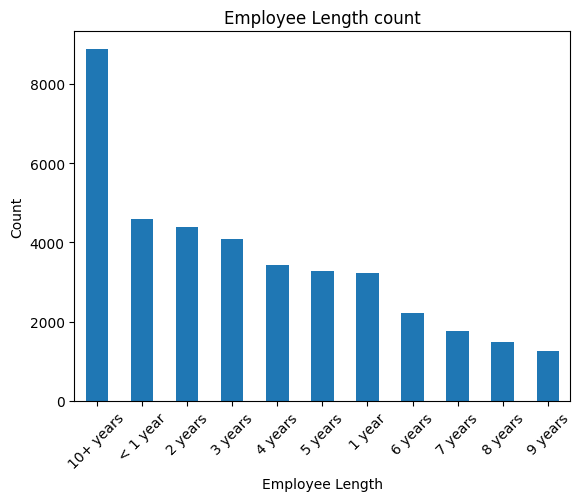

In [16]:
loan['emp_length'].value_counts().plot.bar()
plt.title('Employee Length count')
plt.xlabel('Employee Length')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

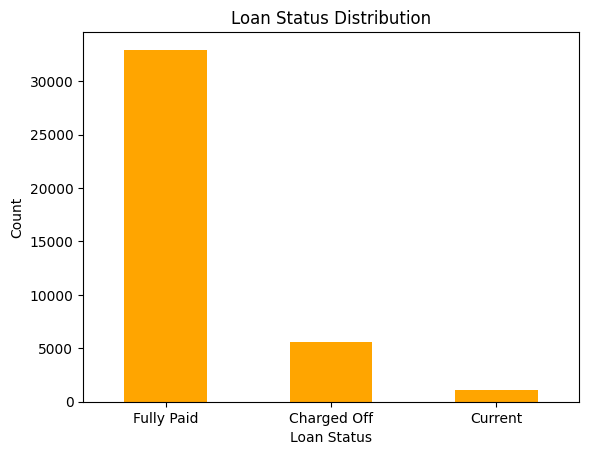

In [17]:
loan['loan_status'].value_counts().plot.bar(color='orange')
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [18]:
loan['loan_status'].value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64

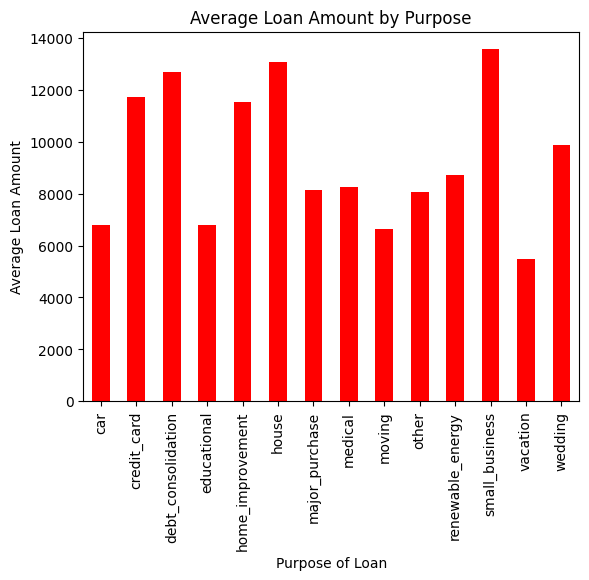

In [38]:
loan_by_purpose = loan.groupby('purpose')['loan_amnt'].mean()
loan_by_purpose.plot.bar(color='red')
plt.xlabel('Purpose of Loan')
plt.ylabel('Average Loan Amount')
plt.title('Average Loan Amount by Purpose')
plt.show()

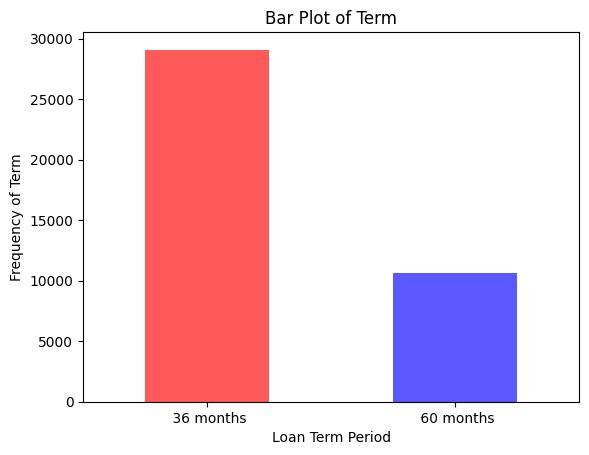

In [40]:
loan['term'].value_counts().plot.bar(color=['red','blue'], alpha=0.65)
plt.title('Bar Plot of Term')
plt.xlabel('Loan Term Period')
plt.ylabel('Frequency of Term')
plt.xticks(rotation=0)
plt.show()


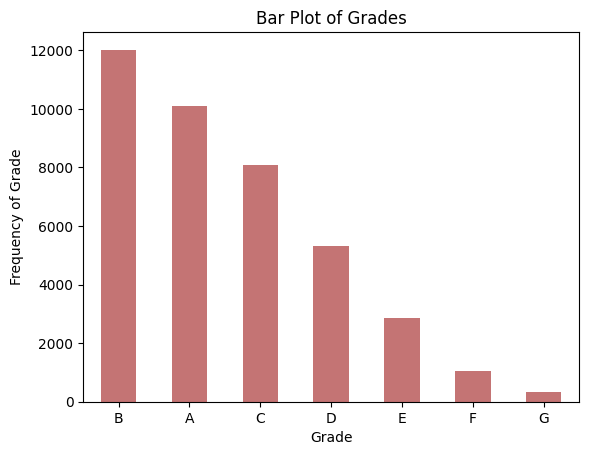

In [42]:
loan['grade'].value_counts().plot.bar(color='Brown', alpha=0.65)
plt.title('Bar Plot of Grades')
plt.xlabel('Grade')
plt.ylabel('Frequency of Grade')
plt.xticks(rotation=0)
plt.show()


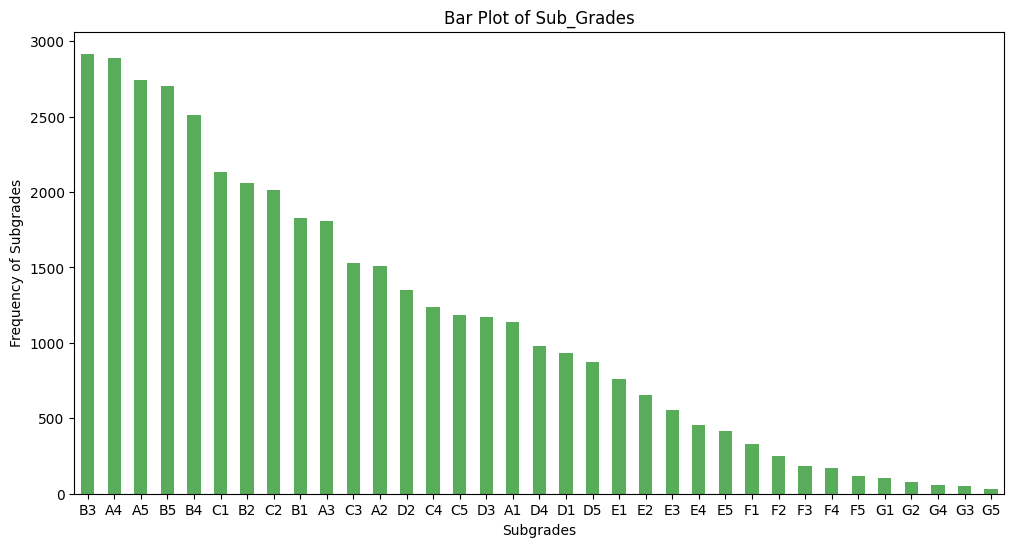

In [44]:
plt.figure(figsize=(12, 6))
loan['sub_grade'].value_counts().plot.bar(color = 'green', alpha=0.65)
plt.title('Bar Plot of Sub_Grades')
plt.xlabel('Subgrades')
plt.ylabel('Frequency of Subgrades')
plt.xticks(rotation=0)
plt.show()


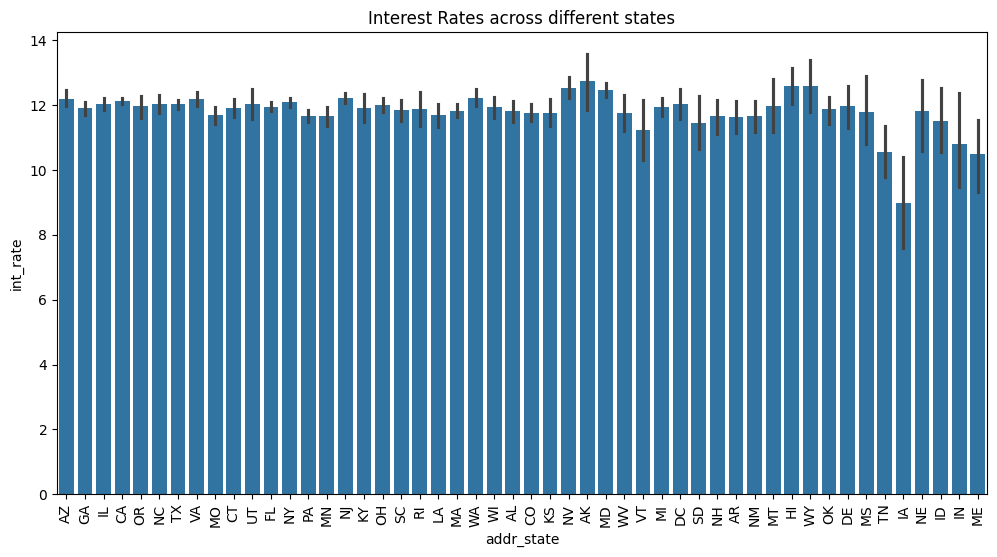

In [45]:
plt.figure(figsize=(12, 6))
sns.barplot(data=loan, y='int_rate', x='addr_state')
plt.title('Interest Rates across different states')
plt.xticks(rotation=90)
plt.show()


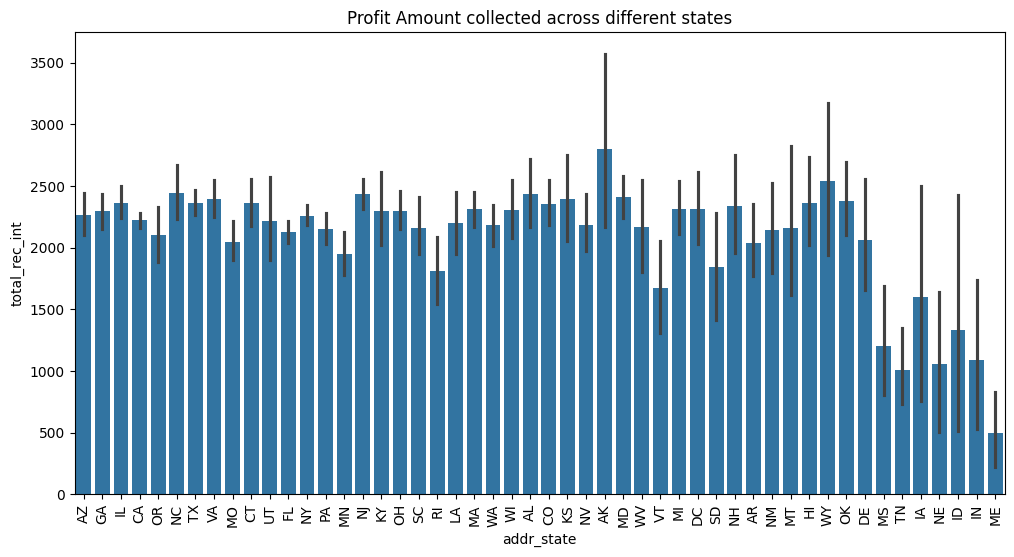

In [46]:
plt.figure(figsize=(12, 6))
sns.barplot(data=loan, y='total_rec_int', x='addr_state')
plt.xticks(rotation=90)
plt.title('Profit Amount collected across different states')
plt.show()


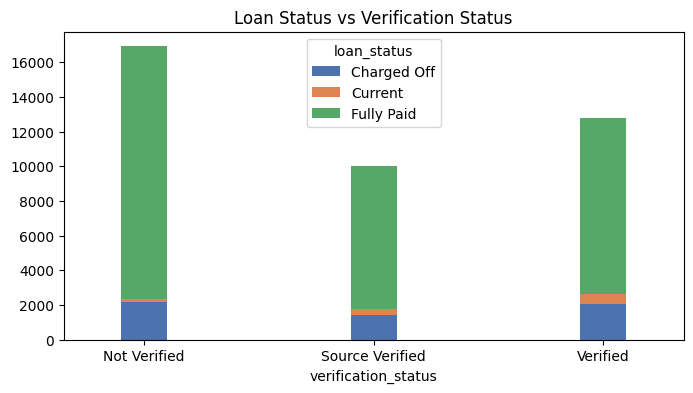

In [47]:
sns.set_palette("deep")
pivot_table2 = loan.pivot_table(index='verification_status', columns='loan_status', aggfunc='size')
pivot_table2.plot(kind='bar', stacked=True, figsize=(8, 4), width=0.2)
plt.xticks(rotation=0)
plt.title('Loan Status vs Verification Status')
plt.show()


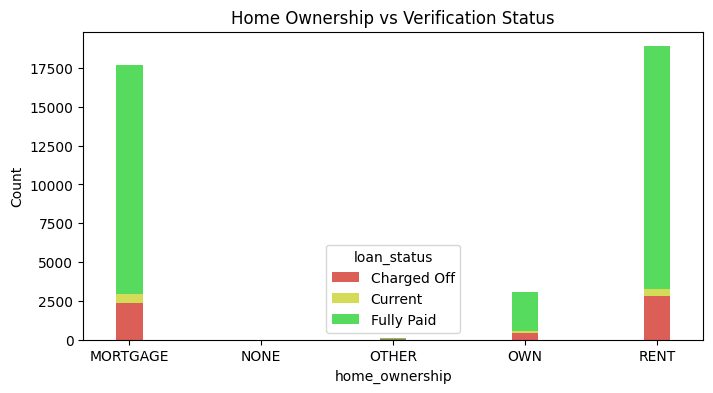

In [48]:
sns.set_palette("hls")
pivot_table3 = loan.pivot_table(index='home_ownership', columns='loan_status', aggfunc='size')
pivot_table3.plot(kind='bar', stacked=True, figsize=(8, 4), width=0.2)
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Home Ownership vs Verification Status')
plt.show()


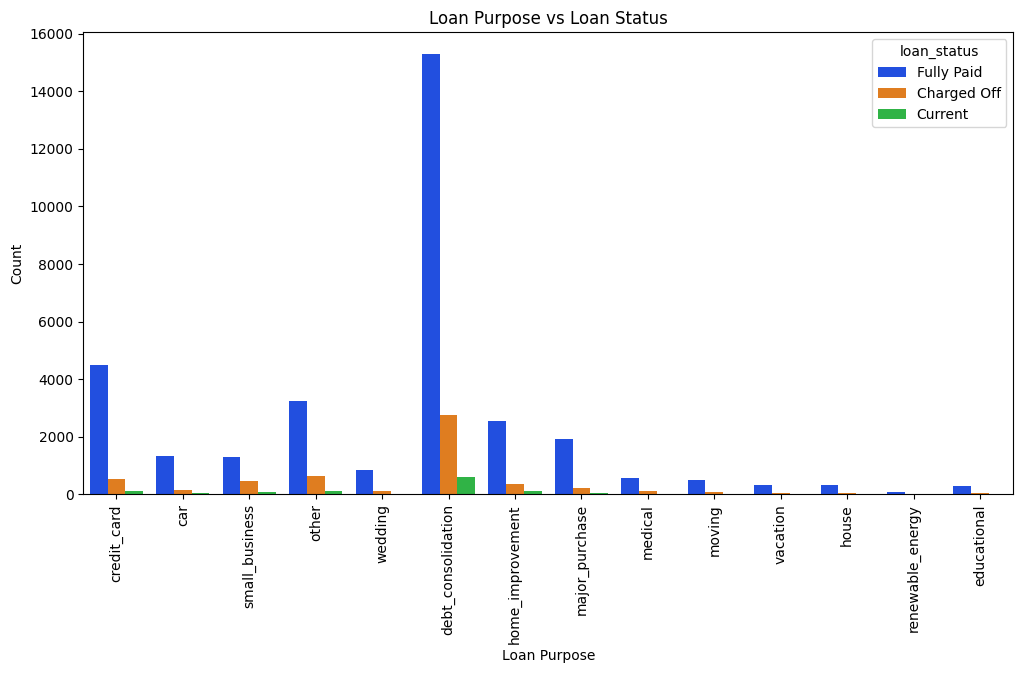

In [49]:
plt.figure(figsize=(12, 6))
sns.set_palette("bright")
sns.countplot(x='purpose', hue='loan_status', data=loan, width=0.8)
plt.title('Loan Purpose vs Loan Status')
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

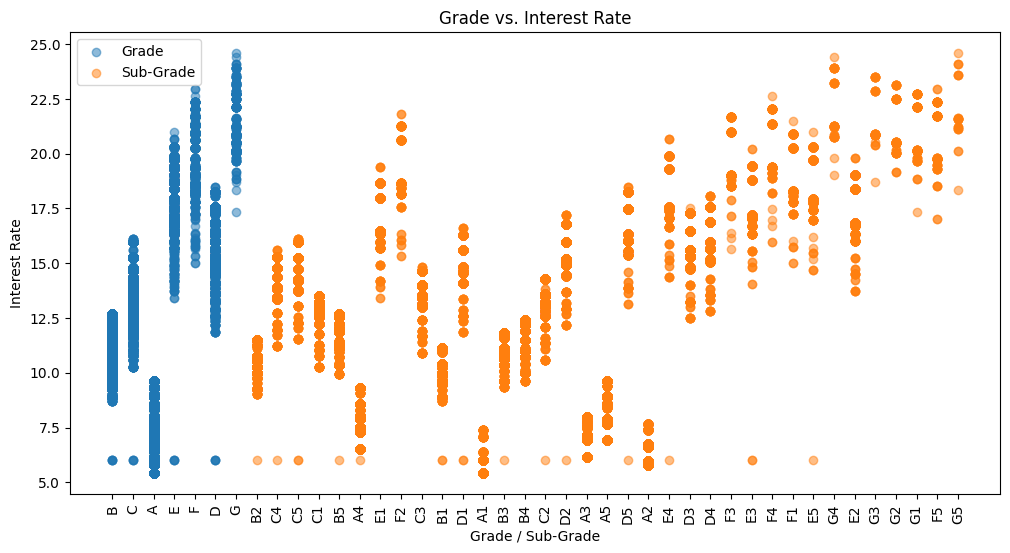

In [20]:
plt.figure(figsize=(12, 6))
plt.scatter(loan['grade'], loan['int_rate'], alpha=0.5, label='Grade', cmap='viridis')
plt.scatter(loan['sub_grade'], loan['int_rate'], alpha=0.5, label='Sub-Grade', cmap='viridis')
plt.xlabel('Grade / Sub-Grade')
plt.ylabel('Interest Rate')
plt.title('Grade vs. Interest Rate')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Driving Factors

### Let’s take a loan candidate. Let's say we are evaluating the application of a candidate with id 1069102.

In [21]:
loan_candidate = loan[loan['id'] == '1069102']

## DrivingFactor-1: Employment Length

#### Below box plot shows that, amongst all the applicants, the given loan applicant has good employment length. Therefore, he is likely to have a stable income source and has lower credit risk.

In [22]:
loan_candidate = loan[loan['id'] == '1069102']

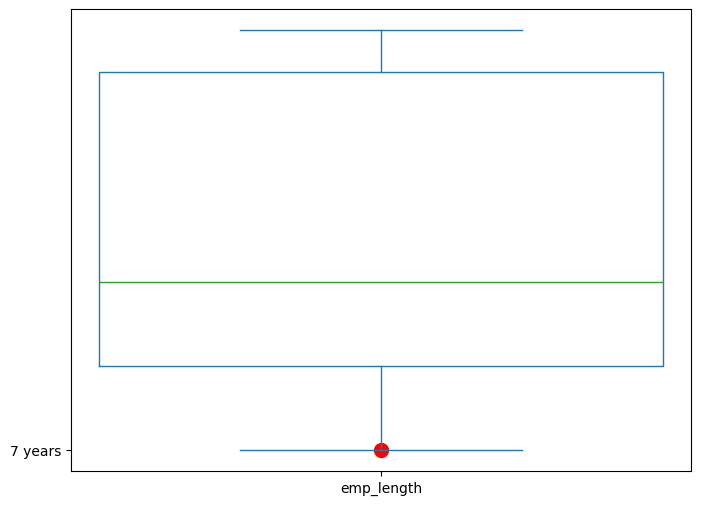

In [23]:
loan['emp_length'] = loan['emp_length'].fillna(0)
loan['emp_length'] = loan['emp_length'].apply(lambda x: int(str(x).replace('+', '').replace('<', '').replace('years', '').replace('year', '')))
plt.figure(figsize=(8, 6))
loan['emp_length'].plot(kind = 'box')
plt.scatter(range(1, 2), loan_candidate['emp_length'], color='red', marker='o', s=100, label='Single Row')
plt.show()

## DrivingFactor-2: Home Ownership

#### Below plot shows home ownership vs loan status. We can see that applicants having own home are less likely to get charged off

In [24]:
print('home ownership status of the candidate is', loan_candidate['home_ownership'].iloc[0])

home ownership status of the candidate is MORTGAGE


#### Given candidate's home ownership is MORTGAGE, hence he is doesn't have low credit risk from this parameter.

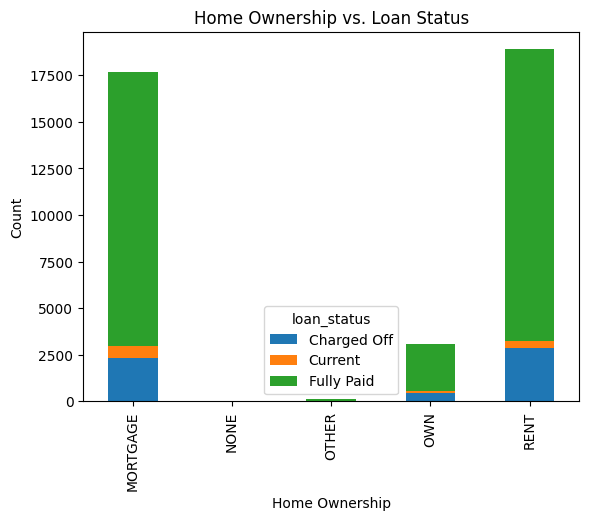

In [25]:
pivot_table = loan.pivot_table(index='home_ownership', columns='loan_status', aggfunc='size')
pivot_table.plot(kind='bar', stacked=True)
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.title('Home Ownership vs. Loan Status')
plt.show()

## DrivingFactor-3: State Wise Analysis
#### State-wise data for loan status.

In [26]:
print('Given candidate is from state', loan_candidate['addr_state'].iloc[0])

Given candidate is from state OH


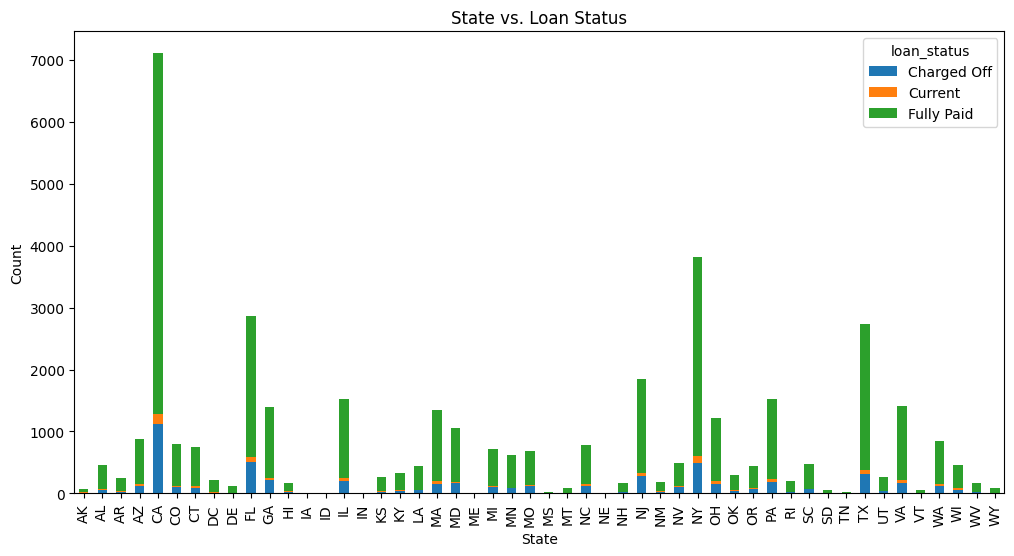

In [27]:
pivot_table = loan.pivot_table(index='addr_state', columns='loan_status', aggfunc='size')
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('State')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('State vs. Loan Status')
plt.show()

## DrivingFactor-4: Revolving Line Utilization

#### Lower revolving line utilization indicates lower credit risk of the candidate.

In [28]:
loan['revol_util'] = loan['revol_util'].fillna(0)
loan['revol_util'] = loan['revol_util'].apply(lambda x: 0 if x=='0' else float(str(x).rstrip('%')))
#loan['revol_util'].value_counts()

In [29]:
print('There is a negative correlation of loan default for revol_util', loan['revol_util'].corr(loan['loan_status_deriv']))

There is a negative correlation of loan default for revol_util -0.10038886600683893


#### As seen in the below plot, candidate has lower credit risk then median wrt revolving line utilization.

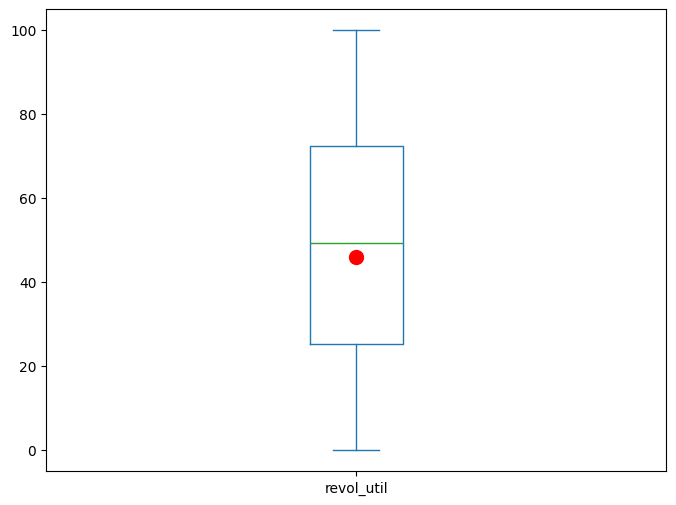

In [30]:
loan_candidate = loan[loan['id'] == '1069102']


plt.figure(figsize=(8, 6))
loan['revol_util'].plot(kind = 'box')
plt.scatter(range(1, 2), loan_candidate['revol_util'], color='red', marker='o', s=100, label='Single Row')
plt.show()

## DrivingFactor-5: Derived Column: Paying Capacity

#### As shown in the below plot, candidate has good paying capacity for the loan given his/her annual income

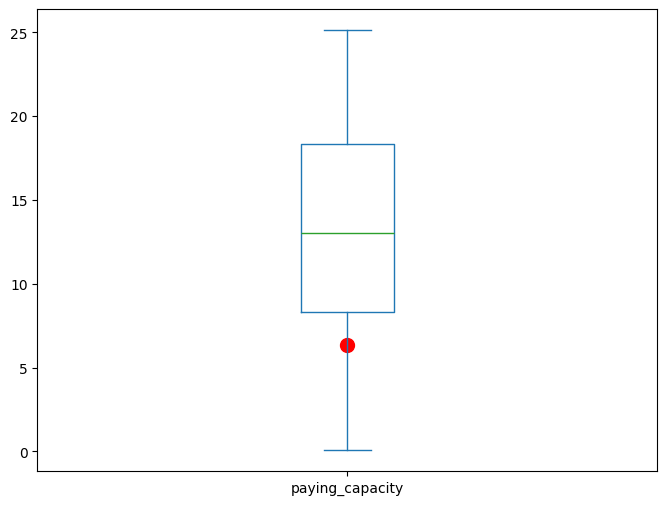

In [31]:
loan_candidate = loan[loan['id'] == '1069102']

q75 = loan['paying_capacity'].quantile(0.75)
filtered_paying_capacity = loan[loan['paying_capacity'] < q75]

plt.figure(figsize=(8, 6))
filtered_paying_capacity['paying_capacity'].plot(kind = 'box')
plt.scatter(range(1, 2), loan_candidate['paying_capacity'], color='red', marker='o', s=100, label='Single Row')
plt.show()

## DrivingFactor-6: Interest Rate

#### Candidates already having loans with higher interest rates have higher credit default risk.

In [32]:
loan['int_rate'].corr(loan['loan_status_deriv'])

np.float64(-0.22682244008258606)

#### As shown in below plot, candidate has ongoing loans with interest rates lower than 50% compared to others.

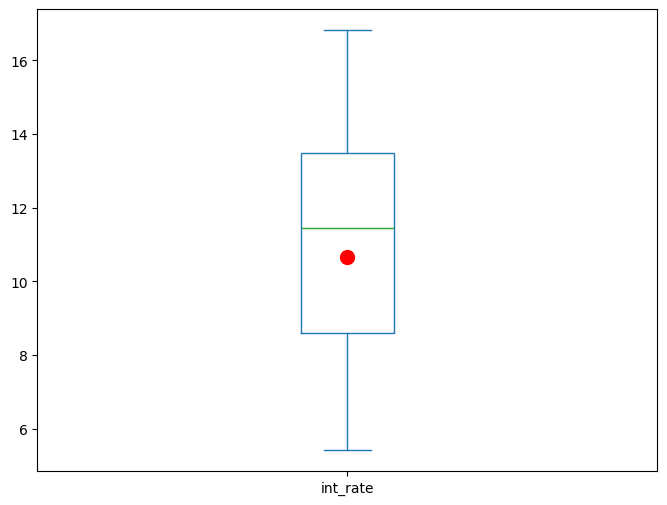

In [33]:
loan_candidate = loan[loan['id'] == '1069102']

q75 = loan['int_rate'].quantile(0.9)
filtered_int_rate = loan[loan['int_rate'] < q75]

plt.figure(figsize=(8, 6))
filtered_int_rate['int_rate'].plot(kind = 'box')
plt.scatter(range(1, 2), loan_candidate['int_rate'], color='red', marker='o', s=100, label='Single Row')
plt.show()

## DrivingFactor-7: Annual Income

#### Candidates having higher annual incomes have lower credit default risk. Also, if income source is verified, then it is a stronger indicator of lower credit risk of the candidate.

In [34]:
loan['annual_inc'].corr(loan['loan_status_deriv'])

np.float64(0.03705341049871744)

In [35]:
verified_annual_inc = loan[loan['verification_status'] != 'Not Verified']['annual_inc']
verified_annual_inc.corr(loan['loan_status_deriv'])

np.float64(0.04706873030727203)

#### As shown in below plot, candidate has higher income than 50% of other candidates, which indicates lower credit risk.

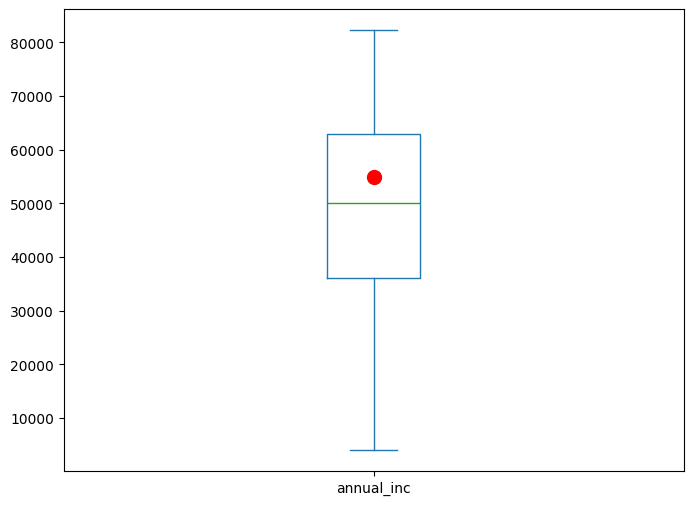

In [36]:
loan_candidate = loan[loan['id'] == '1069102']

q75 = loan['annual_inc'].quantile(0.75)
filtered_loan = loan[loan['annual_inc'] < q75]

plt.figure(figsize=(8, 6))
filtered_loan['annual_inc'].plot(kind = 'box')
plt.scatter(range(1, 2), loan_candidate['annual_inc'], color='red', marker='o', s=100, label='Single Row')
plt.show()

## Bivariate Analysis

### Candidates having higher public record of bankruptcy and higher public derogatory records have higher credit default risk.

In [37]:
loan['pub_rec_bankruptcies'] = loan['pub_rec_bankruptcies'].fillna(0)
loan['pub_rec_bankruptcies'] = loan['pub_rec_bankruptcies'].astype('int32')

loan['pub_rec'] = loan['pub_rec'].fillna(0)
loan['pub_rec'] = loan['pub_rec'].astype('int32')

print('There is a negative correlation of loan default for public bankruptcy records', loan['pub_rec_bankruptcies'].corr(loan['loan_status_deriv']))
print('There is a negative correlation of loan default for public derogatory records', loan['pub_rec'].corr(loan['loan_status_deriv']))
print('candidate has total public bankruptcy records: ', loan_candidate['pub_rec_bankruptcies'].iloc[0])
print('candidate has total public derogatory records: ', loan_candidate['pub_rec'].iloc[0])

There is a negative correlation of loan default for public bankruptcy records -0.04477231147893261
There is a negative correlation of loan default for public derogatory records -0.04821184032185699
candidate has total public bankruptcy records:  0
candidate has total public derogatory records:  0
